## **XGBoost Classifier**  
XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm. The stochastic gradient boosting algorithm, also called gradient boosting machines or tree boosting, is a powerful machine learning technique that performs well or even best on a wide range of challenging machine learning problems.  
It is an ensemble of decision trees algorithm where new trees fix errors of those trees that are already part of the model. Trees are added until no further improvements can be made to the model.  XGBoost is an effective machine learning model, even on datasets where the class distribution is skewed.  
Before any modification or tuning is made to the XGBoost algorithm for imbalanced classification, it is essential to test the default XGBoost model and establish a performance baseline.

In [1]:
import numpy as np # for numeric computation
import pandas as pd # for handling data in table format
pd.set_option('display.max_rows', 200)
import requests # for retrieving web addresses
import io # for storing data
import plotly.express as px # for visualization
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')

## **Import Data**

In [2]:
# Clone Git Repo
!git clone -l -s git://github.com/adamehayman/AMII.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 223 (delta 30), reused 41 (delta 15), pack-reused 163
Receiving objects: 100% (223/223), 63.82 MiB | 24.70 MiB/s, done.
Resolving deltas: 100% (118/118), done.
/content/cloned-repo
1_NASA_FD001_EDA.ipynb			   6_Class_Models_Stacking.ipynb
2_10_Class_Decision_Tree_Classifier.ipynb  FIgures.pptx
3_5_Class_Decision_Tree_Classifier.ipynb   NASA_TurboFan_Data
4_RandomForest.ipynb			   README.md
5_XGBoost.ipynb


In [3]:
X_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/X_train_scaled.csv')
y_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/y_train.csv')

X_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/X_val_scaled.csv')
y_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/y_val.csv')

X_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/X_test_scaled.csv')
y_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/y_test.csv')

In [4]:
sensors = ['T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'w31', 'w32']

In [5]:
pip install xgboost

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from numpy import mean
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

## **XGBoost Model Training**  

In [7]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [8]:
#store data, all in numpy arrays
training_data = {'X_train':X_train,'y_train':y_train,
                'X_val': X_val,'y_val':y_val,
                'X_test': X_test,'y_test':y_test}

In [9]:
#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()

In [10]:
def fitXgb(sk_model, training_data=training_data,epochs=300):
    print('Fitting model...')
    sk_model.fit(training_data['X_train'], training_data['y_train'].reshape(training_data['y_train'].shape[0],))
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['y_train'])
    val = xgb.DMatrix(training_data['X_val'], label=training_data['y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(training_data['X_test']), training_data['y_test'])))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(training_data['X_test']),training_data['y_test'],average='micro')))
    plot_compare(metrics,store,epochs)
    features = sensors
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

### **Initial Model**

Fitting model...
Fitting done!
[0]	val-mlogloss:1.70546	val-merror:0.499921	train-mlogloss:1.70462	train-merror:0.490379
[100]	val-mlogloss:0.892378	val-merror:0.409343	train-mlogloss:0.872553	train-merror:0.392965
[200]	val-mlogloss:0.816569	val-merror:0.365083	train-mlogloss:0.788356	train-merror:0.346583
[299]	val-mlogloss:0.77927	val-merror:0.347981	train-mlogloss:0.74337	train-merror:0.322373
-- Model Report --
XGBoost Accuracy: 0.7271686010995724
XGBoost F1-Score (Micro): 0.7271686010995724


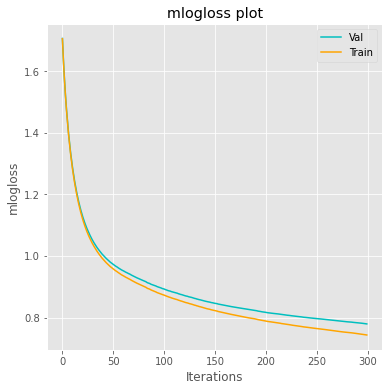

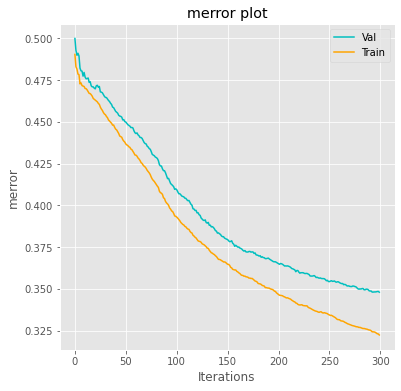

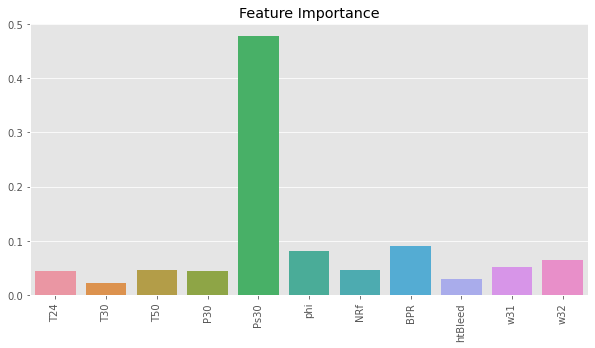

In [11]:
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=100,
                    objective='multi:softmax',
                    num_class=6,
                    seed=42)
fitXgb(xgb1, training_data)

#### **Initial Model Evaluation**

In [12]:
pip install -U yellowbrick

     |████████████████████████████████| 276kB 13.9MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


##### **Classification Report**

In [13]:
from yellowbrick.classifier import ClassificationReport

**Validation Set**

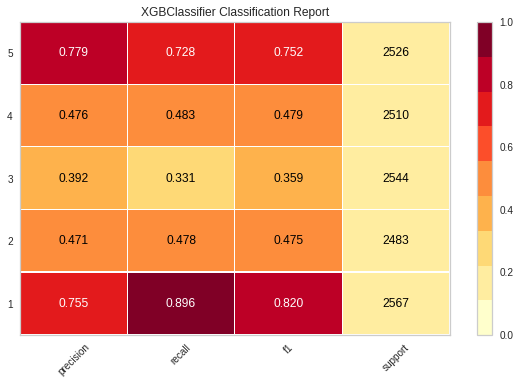

In [14]:
viz = ClassificationReport((xgb1), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

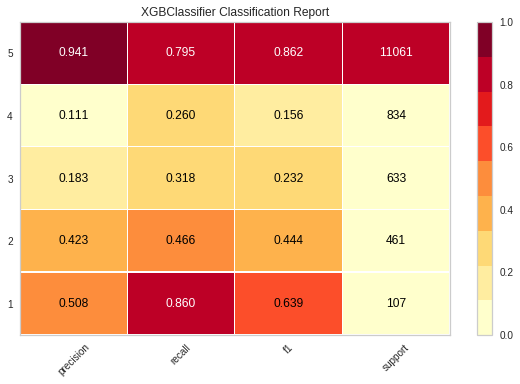

In [15]:
viz = ClassificationReport((xgb1), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
g=viz.poof()

##### **ROC-AUC Receiver Operating Characteristic**

In [16]:
from yellowbrick.classifier import ROCAUC

**Validation Set**

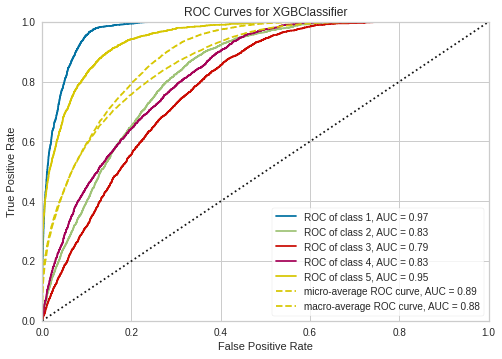

In [17]:
model = xgb1
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_val, y_val)
visualizer.show()

**Test Set**

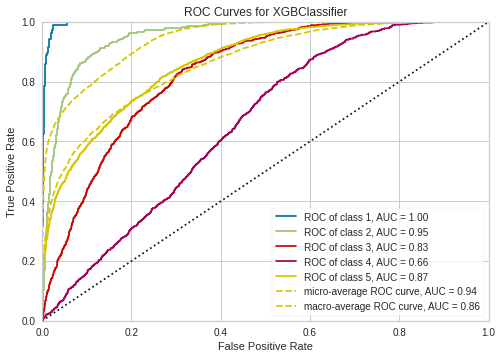

In [18]:
model = xgb1
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_test, y_test)
visualizer.show()

##### **Precision-Recall Curves**

In [19]:
from yellowbrick.classifier import PrecisionRecallCurve

**Validation Set**

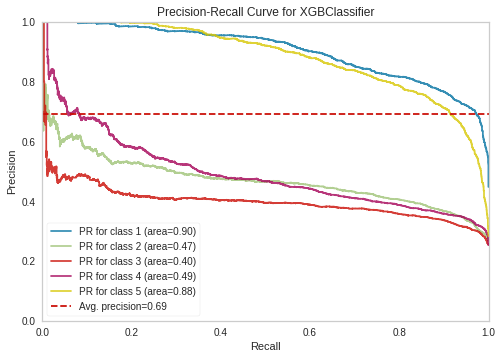

In [20]:
viz = PrecisionRecallCurve((xgb1), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

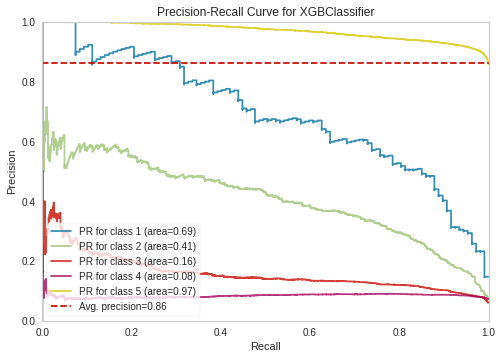

In [21]:
viz = PrecisionRecallCurve((xgb1), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Class Prediction Error**  

In [22]:
from yellowbrick.classifier import ClassPredictionError

**Validation Set**

In [23]:
y_val = y_val.flatten()

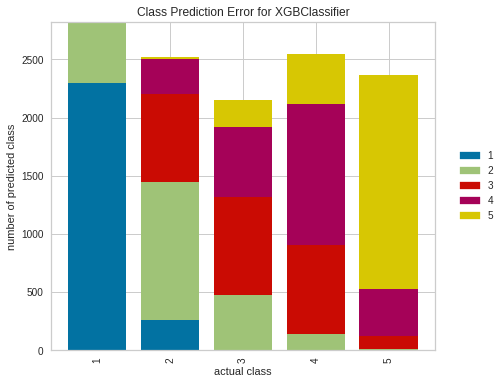

In [24]:
viz = ClassPredictionError((xgb1), per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

In [25]:
y_test = y_test.flatten()

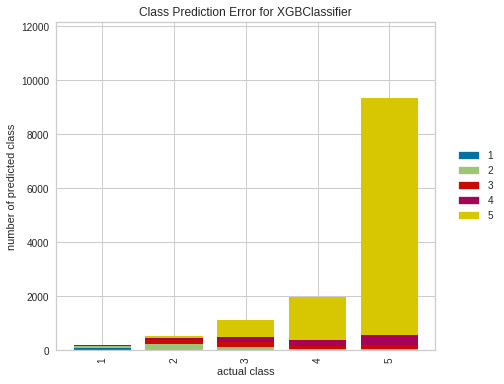

In [26]:
viz = ClassPredictionError(xgb1)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Confusion Matrix**  

In [27]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

**Validation Set**

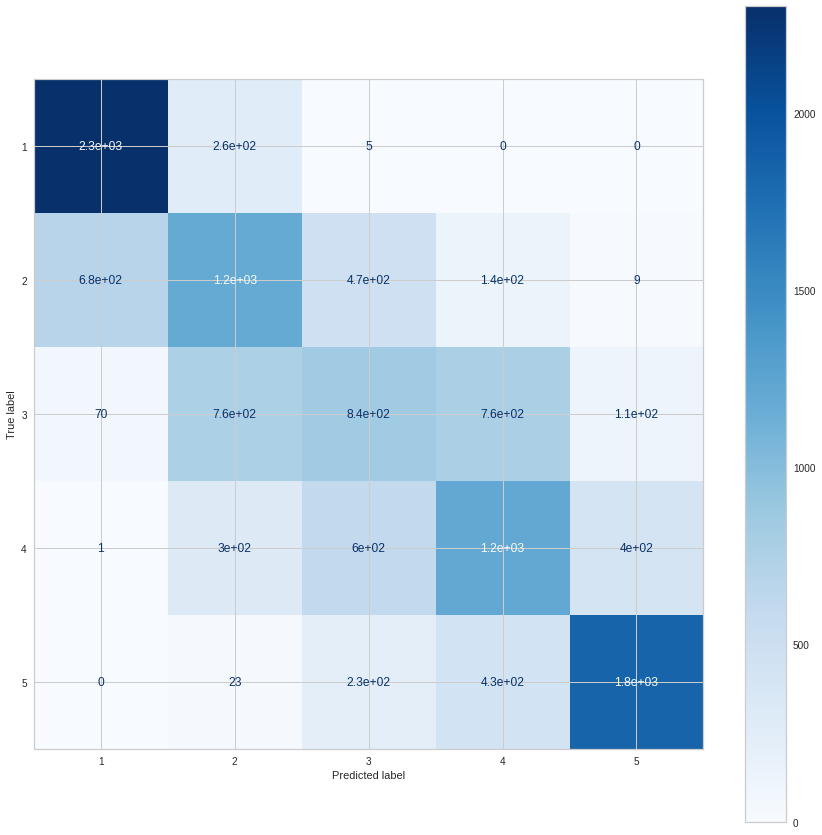

In [28]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(xgb1, X_val, y_val, cmap=plt.cm.Blues, ax=ax)

**Test Set**

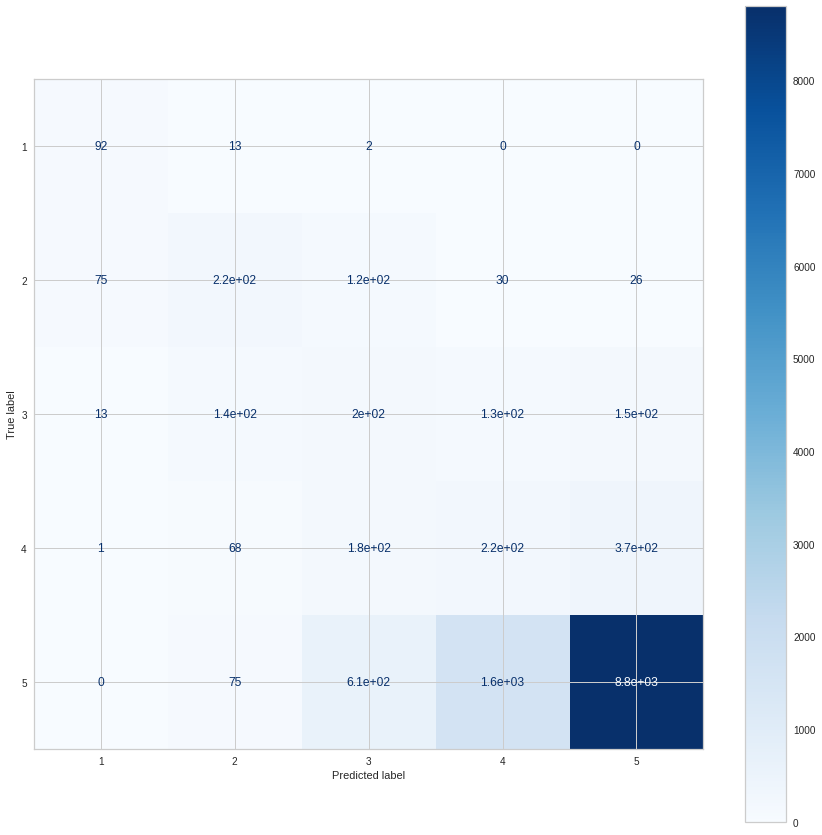

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(xgb1, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

### **Set tree_method and scale_pos_weight**  
  
Frist, we set the tree_method to "hist" to speed up computations. Then we set the scale_pos_weight to 10 to account for class imbalance. There are roughly 10 times as many "negative" class samples, (Classes 2-5) compared to "positive" Class 1 samples.

In [30]:
# Define scoring strategy
weighted_recall = make_scorer(recall_score, average='weighted')

In [31]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

Fitting model...
Fitting done!
[0]	val-mlogloss:1.70589	val-merror:0.497229	train-mlogloss:1.70518	train-merror:0.490162
[100]	val-mlogloss:0.898539	val-merror:0.416944	train-mlogloss:0.879895	train-merror:0.398567
[200]	val-mlogloss:0.828249	val-merror:0.373713	train-mlogloss:0.802599	train-merror:0.355293
[299]	val-mlogloss:0.791561	val-merror:0.358591	train-mlogloss:0.759019	train-merror:0.33433
-- Model Report --
XGBoost Accuracy: 0.7172419059254734
XGBoost F1-Score (Micro): 0.7172419059254735


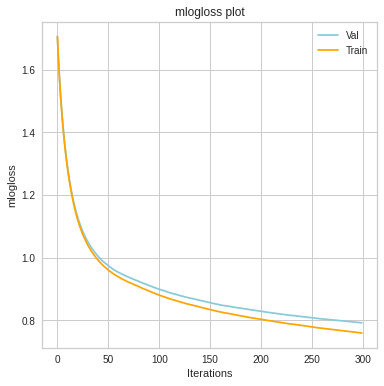

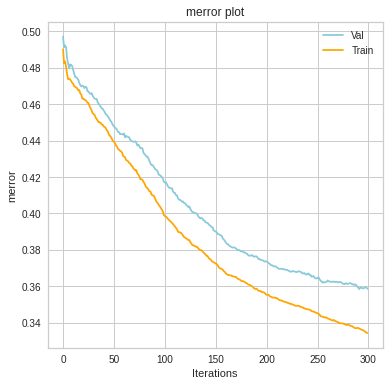

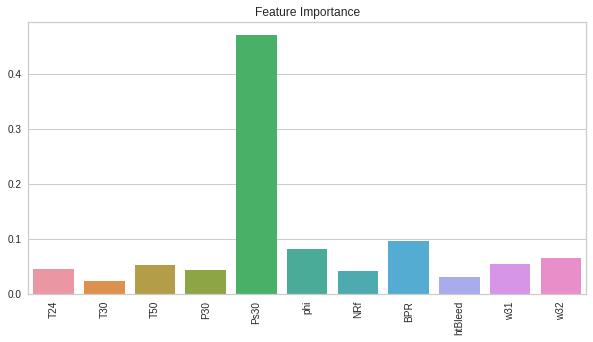

In [32]:
xgb2 = XGBClassifier(tree_method='hist',
                    scale_pos_weight=10,
                    eval_metric='merror',
                    learning_rate=0.1,
                    n_estimators=100,
                    objective='multi:softmax',
                    num_class=6,
                    seed=42)
fitXgb(xgb2, training_data)

In [ ]:
viz = ClassificationReport((xgb2), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
g=viz.poof()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(xgb2, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

### **Tune n_estimators**

In [ ]:
param_test2 = {
 'n_estimators':range(100,1000,50),
}
gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_test2, scoring=weighted_recall, n_jobs=-1,verbose = 10, cv=3)
gsearch2.fit(X_train, y_train)

In [ ]:
getTrainScores(gsearch2)

From the above GridSearch, we see that the best parameters for n_estimators is 950, which is at the upper threshold of our search. Chances are the model would like to keep using more estimators which would severly overfit our data and become extremely computaitonaly and memory demanding. We will try 300 from personal experience.

In [ ]:
xgb3 = XGBClassifier(tree_method='hist',
                    scale_pos_weight=10,
                    eval_metric='merror',
                    learning_rate=0.1,
                    n_estimators=300,
                    objective='multi:softmax',
                    num_class=6,
                    seed=42)
fitXgb(xgb3, training_data)

In [ ]:
viz = ClassificationReport((xgb3), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
g=viz.poof()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(xgb3, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

Increasing the number of estimators did not improve our model, in fact it decreased our Class 1 accuracy.

### **Tune reg_alpha**

In [ ]:
param_test3 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch3 = GridSearchCV(estimator = xgb2, param_grid = param_test3, scoring=weighted_recall, n_jobs=-1,verbose = 10, cv=3)
gsearch3.fit(X_train, y_train)

In [ ]:
getTrainScores(gsearch3)

From the above GridSearch, we see that the best parameters for reg_alpha is 0.1, which is the default value so we will not see any change in our model performance.

In [ ]:
xgb4 = XGBClassifier(tree_method='hist',
                    scale_pos_weight=10,
                    eval_metric='merror',
                    reg_alpha=0.1,
                    learning_rate=0.1,
                    n_estimators=100,
                    objective='multi:softmax',
                    num_class=6,
                    seed=42)
fitXgb(xgb4, training_data)

In [ ]:
viz = ClassificationReport((xgb4), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
g=viz.poof()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(xgb4, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

### **Final Model xgb2 Evaluation**  
We did not perform an exhaustive search, but the few parameters that we did search through did not significantly improve our model. The best performing model was xgb2, where the tree_method was set to "hist" and the scale_pos_weight was set to 10.

#### **Model Evaluation**

##### **Classification Report**

In [33]:
from yellowbrick.classifier import ClassificationReport

**Validation Set**

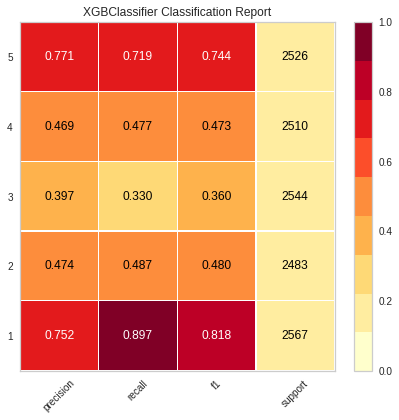

In [34]:
viz = ClassificationReport((xgb2), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

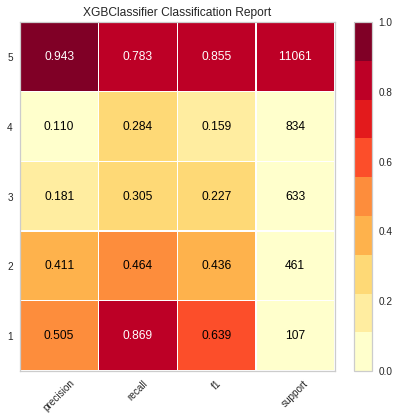

In [51]:
viz = ClassificationReport((xgb2), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **ROC-AUC Receiver Operating Characteristic**

In [36]:
from yellowbrick.classifier import ROCAUC

**Validation Set**

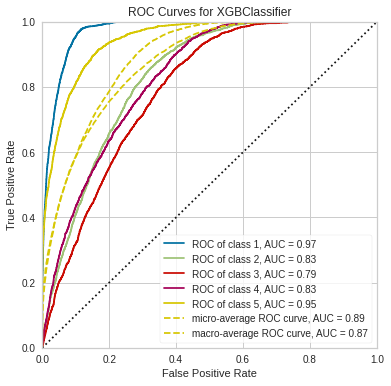

In [37]:
model = xgb2
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_val, y_val)
visualizer.show()

**Test Set**

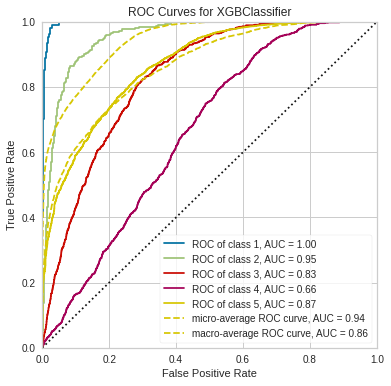

In [38]:
model = xgb2
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_test, y_test)
visualizer.show()

##### **Precision-Recall Curves**

In [39]:
from yellowbrick.classifier import PrecisionRecallCurve

**Validation Set**

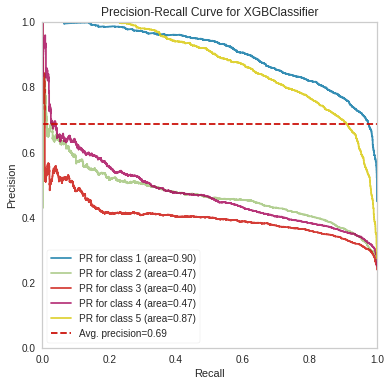

In [40]:
viz = PrecisionRecallCurve((xgb2), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

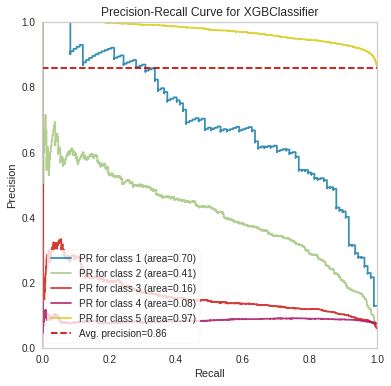

In [41]:
viz = PrecisionRecallCurve((xgb2), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Class Prediction Error**  

In [42]:
from yellowbrick.classifier import ClassPredictionError

**Validation Set**

In [43]:
y_val = y_val.flatten()

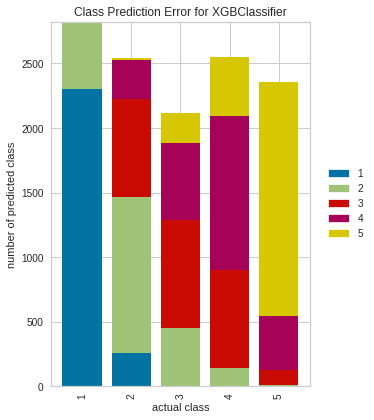

In [44]:
viz = ClassPredictionError((xgb2), per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

In [45]:
y_test = y_test.flatten()

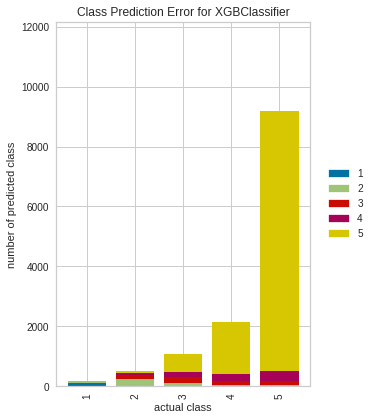

In [46]:
viz = ClassPredictionError(xgb2)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Confusion Matrix**  

In [47]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

**Validation Set**

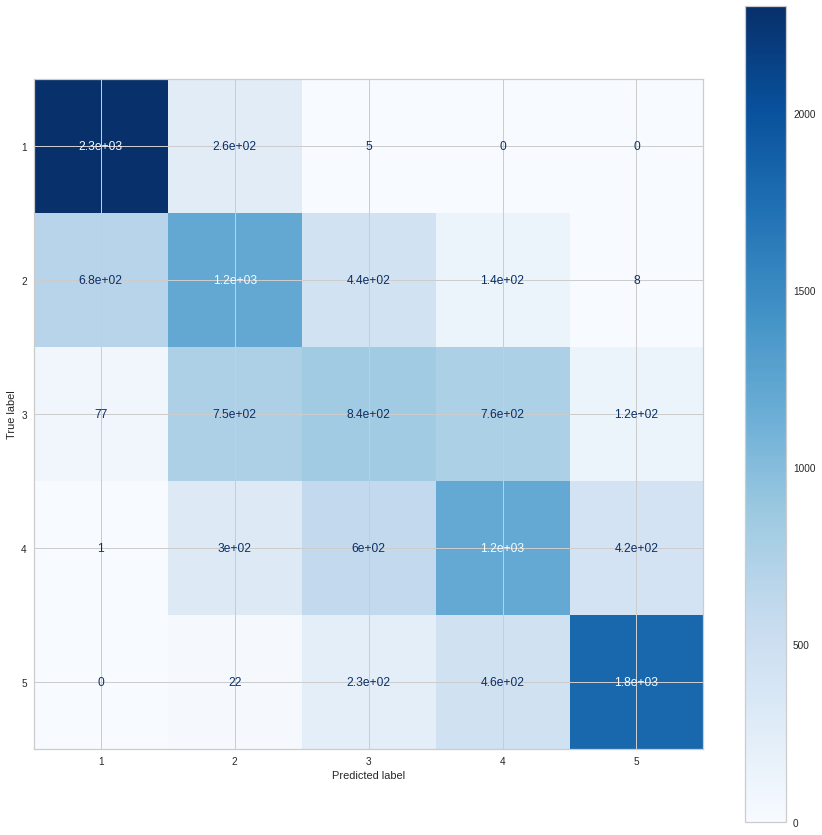

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(xgb2, X_val, y_val, cmap=plt.cm.Blues, ax=ax)

**Test Set**

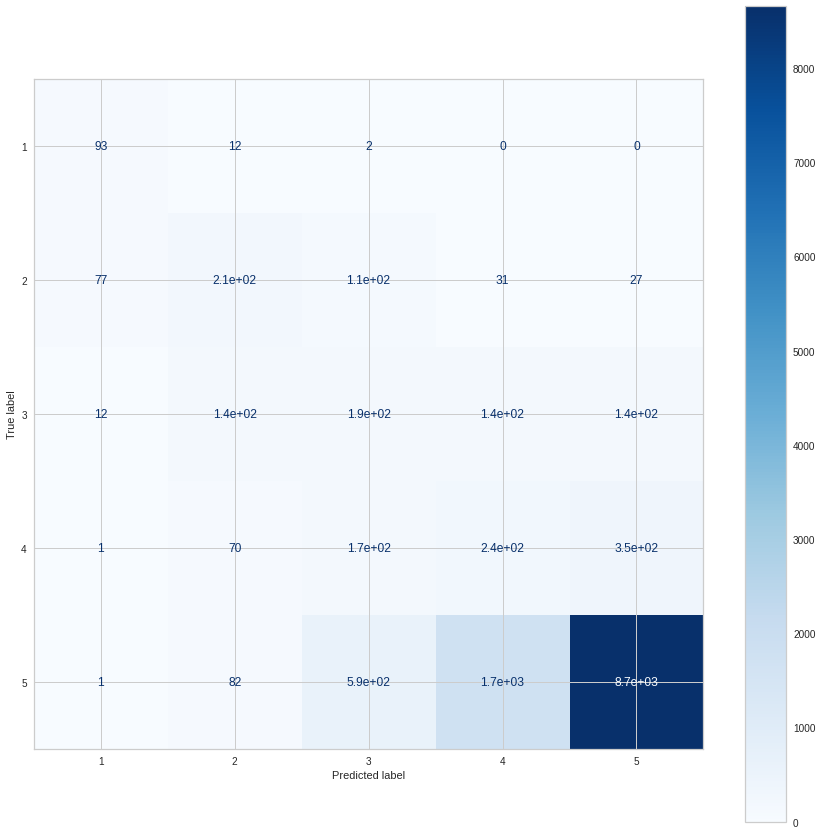

In [49]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(xgb2, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

## **Save Model**

In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [53]:
import joblib

In [54]:
model_save_name = '5_class_XGBoost_Final_Model'
path = F"/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/{model_save_name}"
joblib.dump(xgb2, path)

['/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/5_class_XGBoost_Final_Model']

In [55]:
xgb2 = joblib.load('/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/5_class_XGBoost_Final_Model')

In [56]:
xgb2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, num_class=6, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
              seed=42, silent=None, subsample=1, tree_method='hist',
              verbosity=1)